In [1]:
import numpy as np 
import torch 
import json 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
from parchgrad.plot import quantile_plot, alpha_plot
from parchgrad.models.pretrained_models import get_pretrained_model
from parchgrad import get_hook_wrapper
from parchgrad.datasets import get_default_transform
from parchgrad.datasets import IMAGENET_MEAN, IMAGENET_STD, get_datasets
from parchgrad.attribution_methods import get_input_attrib
import torchvision.transforms as T 
labels = json.load(open("../../imagenet_label.json", 'rb')) 

In [2]:
# --- dataset 
encoder = "vgg16"
device="cuda:0"
base_dir = f"../../data/{encoder}"
model = get_pretrained_model(encoder)
model.to(device)
model.eval()

method = 'cls'
wrapper = get_hook_wrapper(encoder, model, method)  # just use cls to gather forward hiddens 
wrapper.prepare_parchgrad(base_directory=base_dir, device=device)

We set all module's inplace=False


In [3]:
data_path='/data/ImageNet1k/'
transform = get_default_transform(wrapper.resize, wrapper.crop, IMAGENET_MEAN, IMAGENET_STD)
_, valid_dataset = get_datasets('imagenet1k', data_path, transform)
transform_2 = T.Compose([
                T.Resize(wrapper.resize, interpolation=T.InterpolationMode.BILINEAR),
                T.CenterCrop(wrapper.crop),
                T.ToTensor(),
                ])

_, valid_dataset_2 = get_datasets('imagenet1k', data_path, transform_2)

[INFO] hook upper half convolutions
13240


6it [00:00, 37.10it/s]


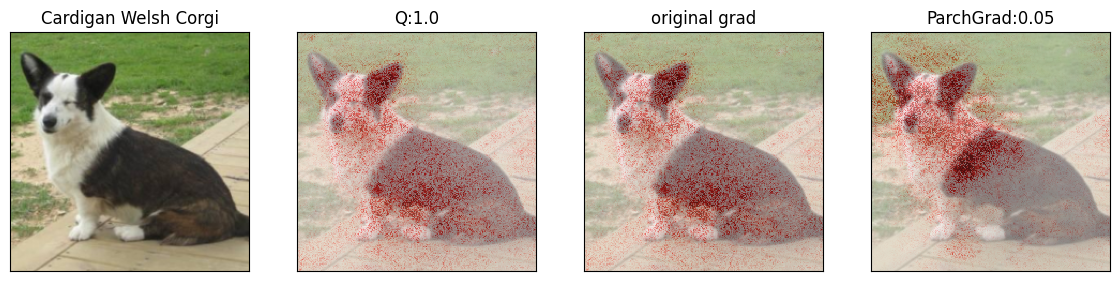

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from tqdm import tqdm 
from matplotlib.colors import ListedColormap
from parchgrad.plot import process_heatmap

layer_ratio=None # 0.5
selected_convolutions = wrapper.get_default_hook_convolutions(layer_ratio)
wrapper.set_hook_modules(selected_convolutions)

flags = OmegaConf.create({
    'method': method,
    'alpha' :None,
    'p_value_threshold' : 0.05, 
    'variance_conservation' : True, 
    'exact_variance' :False,
    'gamma_infinity': True
})

input_attrib_name ='grad'

index=263*50 + 40 +  50
print(index)
quantiles = [1.0, 0.5, 0.3, 0.1, 0.08, 0.05]
input_attrib = get_input_attrib(input_attrib_name)

x = valid_dataset[index][0].to(device)
y = valid_dataset[index][1]
cls = torch.tensor([y])
x_img = valid_dataset_2[index][0]

# ax.set_ylabel(index)
label = labels[index//50]

imgs = [] 
y = torch.tensor(valid_dataset[index][1]).to(device).unsqueeze(0)
attrs = [] 
kwargss = []
for i, wrapper in enumerate([wrapper]):
    my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))    
    for j, quantile in tqdm(enumerate(quantiles)):
        flags.quantile = quantile
        attr = input_attrib(wrapper, x, y, 
                cls=y, 
                modify_gradient=False if flags.method == 'normal' else True,
                quantile=flags.quantile,
                alpha=flags.alpha,
                p_value_threshold=flags.p_value_threshold,
                variance_conservation=flags.variance_conservation,
                exact_variance=flags.exact_variance,
                gamma_infinity=flags.gamma_infinity,
                enable_forward_hook=True if flags.method == 'ins' else False, 
                )
        attr = attr.cpu()
        attr, kwargs  = process_heatmap(attr, my_cmap)
        attrs.append(attr)
        kwargss.append(kwargs)
        # ax.imshow((x_img.permute(1,2,0)), alpha=0.8) 
        # im = ax.imshow(attr.cpu().numpy(), **kwargs, alpha=0.85)
        # ax.set_title(f"Q:{quantile}")
        # ax.set_xticks([])
        # ax.set_yticks([])
        
        
def animate(i):
    img = axes[1].imshow(x_img.permute(1,2,0), alpha=0.8)
    img = axes[1].imshow(attrs[i], alpha=0.5, **kwargss[i])
    img = axes[1].set_title(f"Q:{quantiles[i]}")
    return img,

fig, axes = plt.subplots(1,4, figsize=(11, 3))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
axes[0].imshow(x_img.permute(1,2,0))
axes[0].set_title(label,)
for i in range(4):
    axes[i].set_xticks([])
    axes[i].set_yticks([])
axes[2].imshow(x_img.permute(1,2,0))
axes[3].imshow(x_img.permute(1,2,0))
axes[2].imshow(attrs[0], alpha=0.5, **kwargss[0])
axes[3].imshow(attrs[-1], alpha=0.5, **kwargss[-1])
axes[2].set_title(f"original {input_attrib_name}")
axes[3].set_title(f"ParchGrad:{quantiles[-1]}")

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(attrs), interval=1000)
ani.save(f'outputs/{index}.gif',)